In [1]:
class LineDictionary:
    def __init__(self):
        self.lines = {}
        self.Create3x3Lines()
        self.Create5x5Lines()
        self.Create7x7Lines()
        self.Create9x9Lines()
        return
    
    def Create3x3Lines(self):
        lines = {}
        lines[0] = [1,0,1,2]
        lines[45] = [2,0,0,2]
        lines[90] = [0,1,2,1]
        lines[135] = [0,0,2,2]
        self.lines[3] = lines
        return
    
    def Create5x5Lines(self):
        lines = {}        
        lines[0] = [2,0,2,4]
        lines[22.5] = [3,0,1,4]
        lines[45] = [0,4,4,0]
        lines[67.5] = [0,3,4,1]
        lines[90] = [0,2,4,2]
        lines[112.5] = [0,1,4,3]
        lines[135] = [0,0,4,4]
        lines[157.5]= [1,0,3,4]
        self.lines[5] = lines
        return
        
    def Create7x7Lines(self):
        lines = {}
        lines[0] = [3,0,3,6]
        lines[15] = [4,0,2,6]
        lines[30] = [5,0,1,6]
        lines[45] = [6,0,0,6]
        lines[60] = [6,1,0,5]
        lines[75] = [6,2,0,4]
        lines[90] = [0,3,6,3]
        lines[105] = [0,2,6,4]
        lines[120] = [0,1,6,5]
        lines[135] = [0,0,6,6]
        lines[150] = [1,0,5,6]
        lines[165] = [2,0,4,6]
        self.lines[7] = lines 
        return
    
    def Create9x9Lines(self):
        lines = {}
        lines[0] = [4,0,4,8]
        lines[11.25] = [5,0,3,8]
        lines[22.5] = [6,0,2,8]
        lines[33.75] = [7,0,1,8]
        lines[45] = [8,0,0,8]
        lines[56.25] = [8,1,0,7]
        lines[67.5] = [8,2,0,6]
        lines[78.75] = [8,3,0,5]
        lines[90] = [8,4,0,4]
        lines[101.25] = [0,3,8,5]
        lines[112.5] = [0,2,8,6]
        lines[123.75] = [0,1,8,7]
        lines[135] = [0,0,8,8]
        lines[146.25] = [1,0,7,8]
        lines[157.5] = [2,0,6,8]
        lines[168.75] = [3,0,5,8]
        self.lines[9] = lines
        return

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as img
from skimage import color, data, restoration
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as ss
import time
import math
from numba import jit
from scipy.spatial.distance import cdist
from scipy.signal import convolve2d
from skimage.draw import line

In [42]:
lineLengths =[3,5,7,9,11,13,15]
lineTypes = ["full", "right", "left"]

lineDict = LineDictionary()

def LinearMotionBlur_random(img):
    lineLengthIdx = np.random.randint(0, len(lineLengths))
    lineTypeIdx = np.random.randint(0, len(lineTypes)) 
    lineLength = lineLengths[lineLengthIdx]
    lineType = lineTypes[lineTypeIdx]
    lineAngle = randomAngle(lineLength)
    return LinearMotionBlur(img, lineLength, lineAngle, lineType)

def LinearMotionBlur(img, dim, angle, linetype):
    imgarray = np.array(img, dtype="float32")
    kernel = LineKernel(dim, angle, linetype)
    convolved = convolve2d(imgarray, kernel, mode='same', fillvalue=255.0).astype("uint8")
    img = Image.fromarray(convolved)
    return img

def LineKernel(dim, angle, linetype):
    kernelwidth = dim
    kernelCenter = int(math.floor(dim/2))
    angle = SanitizeAngleValue(kernelCenter, angle)
    kernel = np.zeros((kernelwidth, kernelwidth), dtype=np.float32)
    lineAnchors = lineDict.lines[dim][angle]
    if(linetype == 'right'):
        lineAnchors[0] = kernelCenter
        lineAnchors[1] = kernelCenter
    if(linetype == 'left'):
        lineAnchors[2] = kernelCenter
        lineAnchors[3] = kernelCenter
    rr,cc = line(lineAnchors[0], lineAnchors[1], lineAnchors[2], lineAnchors[3])
    kernel[rr,cc]=1
    normalizationFactor = np.count_nonzero(kernel)
    kernel = kernel / normalizationFactor        
    return kernel

def SanitizeAngleValue(kernelCenter, angle):
    numDistinctLines = kernelCenter * 4
    angle = math.fmod(angle, 180.0)
    validLineAngles = np.linspace(0,180, numDistinctLines, endpoint = False)
    angle = nearestValue(angle, validLineAngles)
    return angle

def nearestValue(theta, validAngles):
    idx = (np.abs(validAngles-theta)).argmin()
    return validAngles[idx]

def randomAngle(kerneldim):
    kernelCenter = int(math.floor(kerneldim/2))
    numDistinctLines = kernelCenter * 4
    validLineAngles = np.linspace(0,180, numDistinctLines, endpoint = False)
    angleIdx = np.random.randint(0, len(validLineAngles))
    return int(validLineAngles[angleIdx])


In [7]:
#My function
def Richardson_Iteration(H,kernel,num_its,convolve_method = 0):
    #If convolve_method = 0, we will use the FFT Method
    #Otherwise we will use the normal 2d convolve
    #First compute parameters
    S = kernel #makes life easier
    (N,M) = H.shape #Dimensions of the degraded image
    K,L = S.shape #Size of the Kernel
    I = N - K + 1 # Dimensions of the original image
    J = M - K + 1
    II = np.sum(H) # Total energy of degraded image
    W = .5*np.ones((N,M,num_its)) #This will force the initial condition as the first iteration
    for r in range(num_its-1):
        if convolve_method == 0: 
            temp0 = H/ss.fftconvolve(W[:,:,r],kernel,'same')
            temp1 = ss.fftconvolve(temp0,S[::-1,::-1],'same') #Reverse the Kernel
            W[:,:,r+1] = W[:,:,r]*temp1
        
        else:
            temp0 = H/ss.convolve2d(W[:,:,r],kernel,'same')
            temp1 = ss.convolve2d(temp0,S[::-1,::-1],'same') #Reverse the Kernel
            W[:,:,r+1] = W[:,:,r]*temp1
    return W

In [8]:
#Image Functions
@jit
def im2bw(image): #Black and White Imag
    return 0.2126*image[:,:,0] + 0.7152*image[:,:,1] + 0.0722*image[:,:,2]

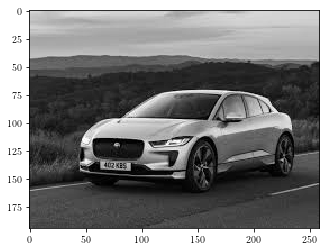

In [11]:
im = img.imread('car.jpg')
f = im2bw(im)
plt.imshow(f,cmap='gray')

In [46]:
flin = ss.convolve2d(f,heinzkern)

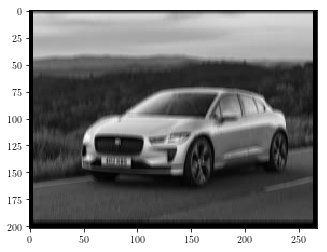

In [50]:
plt.imshow(flin,cmap = 'gray')